In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import nltk

In [3]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

### Load Dataset

In [4]:
data=pd.read_csv('datasets/tweets.csv')

### Check for null values

In [5]:
data.isnull().sum()

tweets    0
labels    0
dtype: int64

In [6]:
#get stopword list
sw_list=stopwords.words('english')

### Since it might affect final outcome, a few words are removed from stopwords list

In [7]:
print(f"Not----->{'not' in sw_list}\nNo------>{'no' in sw_list}\nAgainst->{'against' in sw_list}")

Not----->True
No------>True
Against->True


In [8]:
sw_list.remove('not')
sw_list.remove('no')
sw_list.remove('against')

In [9]:
print(f"Not----->{'not' in sw_list}\nNo------>{'no' in sw_list}\nAgainst->{'against' in sw_list}")

Not----->False
No------>False
Against->False


In [10]:
#Initialize lemmatizer
lemmatizer=WordNetLemmatizer()

### Function to clean tweets

In [11]:
def clean_tweets(tweet):
    #remove RT(retweet tag)
    tweet=re.sub(r"RT @","@",tweet)
    #remove pings
    tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
    #remove URLs
    tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)
    #remove special characters
    tweet = re.sub(r"[^a-zA-Z]", ' ', tweet)
    #convert to lower case
    tweet=tweet.lower()
    #remove extra white spaces
    tweet = re.sub(r" +",' ', tweet)
    #tokenize tweet for removing stopwords and lemmatization
    tokenized_tweet=word_tokenize(tweet)
    #lemmatization of tweet and removing stopwords
    lemmatized_tweet=[lemmatizer.lemmatize(word) for 
                      word in tokenized_tweet if not word in sw_list]
    lemmatized_tweet=' '.join(lemmatized_tweet)
    #remove extra white spaces
    tweet = re.sub(r" +", ' ', tweet)
    return lemmatized_tweet.strip()


In [12]:
data['tweets']=[clean_tweets(tweet) for tweet in data['tweets']]

### Checking and Discarding tweets left empty after cleaning (tweets that contained only retweets, pings and URLs)

In [13]:
data[data['tweets']=='']

,tweets,labels
446,,0
905,,0
1067,,0
1082,,0
1093,,0
1101,,0
1290,,0


In [14]:
len(data)

1364

In [15]:
data.eq('').sum()

tweets    7
labels    0
dtype: int64

In [16]:
data.replace("",np.nan,inplace=True)
data.dropna(subset=['tweets'],inplace=True)
data.eq('').sum()

tweets    0
labels    0
dtype: int64

In [17]:
len(data)

1357

In [18]:
from sklearn.model_selection import train_test_split
X=data['tweets']
y=data['labels']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=7)

In [19]:
lengths=pd.DataFrame(len(tweet.split(' ')) for tweet in X_train)

In [20]:
test_length=pd.DataFrame(len(tweet.split(' ')) for tweet in X_test)

In [21]:
max_len=max(len(tweet.split(' ')) for tweet in X_train)

### Get word count of tweet with most words

In [22]:
max_len

24

## Modeled using : max_features=max_len

### TF-IDF Vectorization

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [24]:
tfidf_vect=TfidfVectorizer(max_features=max_len)
X_train_tfidf=tfidf_vect.fit_transform(X_train).toarray()
X_test_tfidf=tfidf_vect.transform(X_test).toarray()
X_train_tfidf=pd.DataFrame(X_train_tfidf)
X_test_tfidf=pd.DataFrame(X_test_tfidf)

### Combined dataframe of training data

In [25]:
train_data=pd.concat((X_train,y_train),axis=1,ignore_index=True)
train_data.columns=['tweets','labels']
train_data.reset_index(inplace=True,drop=True)
train_data=pd.concat((train_data,X_train_tfidf),axis=1)
train_data

,tweets,labels,0,1,2,3,4,5,6,7,...,14,15,16,17,18,19,20,21,22,23
0,obama admin cry tax increase applaud china low...,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.00000,0.0,0.964659,0.0,0.0,0.000000,0.0,0.000000
1,barack obama longboard package core truck mm b...,0,0.0,0.966024,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
2,edshow whenever obama tell truth gop boo hoo h...,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.96201,...,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
3,many foreign leader obama promised post electi...,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.00000,0.0,0.964659,0.0,0.0,0.000000,0.0,0.000000
4,obama signaled u would accept iranian civilian...,1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,mean saving scotus tell world obama wrong aca ...,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
1081,obama sharpens kansa vision,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
1082,genius man sing else really obama,1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
1083,mitt romney obama spent much time harvard also...,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.49989,0.0,0.000000,0.0,0.0,0.612329,0.0,0.592378


### Combined dataframe of test data

In [26]:
test_data=pd.concat((X_test,y_test),axis=1,ignore_index=True)
test_data.columns=['tweets','labels']
test_data.reset_index(inplace=True,drop=True)
test_data=pd.concat((test_data,X_test_tfidf),axis=1)
test_data

,tweets,labels,0,1,2,3,4,5,6,7,...,14,15,16,17,18,19,20,21,22,23
0,harry style describe michelle obama como una m...,0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,amp si khady president obama got elected nyrel...,0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.70339,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,obama black american really need time whitey f...,0,0.954988,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,whatsromneyhiding throw baseball like man not ...,0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.289185,0.0
4,realclearpolitics obama organizational advanta...,2,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,romney attack obama barnstorming pennsylvania,0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.954745,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
268,obama thug bully not sure call rush limbaugh bill,0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
269,michelle barack obama become like celebrity ta...,0,0.000000,0.758002,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
270,whatsromneyhiding nothing compared mt proof ob...,1,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.947853,0.0


In [27]:
y_train.unique()

array([0, 1, 2], dtype=int64)

In [28]:
from tensorflow.keras.utils import to_categorical
y_train=to_categorical(y_train,3)

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

In [30]:
tf.keras.backend.set_floatx('float64')

In [31]:
model=Sequential()
model.add(Dense(activation='relu',units=64))
model.add(Dropout(0.2))
model.add(Dense(activation='relu',units=32))
model.add(Dense(activation='softmax',units=3))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [32]:
history=model.fit(x=X_train_tfidf,y=y_train,epochs=20)

Epoch 1/20
34/34 [==============================] - 0s 3ms/step - loss: 0.9249 - accuracy: 0.6350
Epoch 2/20
34/34 [==============================] - 0s 2ms/step - loss: 0.7819 - accuracy: 0.6839
Epoch 3/20
34/34 [==============================] - 0s 3ms/step - loss: 0.7436 - accuracy: 0.6839
Epoch 4/20
34/34 [==============================] - 0s 3ms/step - loss: 0.7289 - accuracy: 0.6839
Epoch 5/20
34/34 [==============================] - 0s 3ms/step - loss: 0.7128 - accuracy: 0.7023
Epoch 6/20
34/34 [==============================] - 0s 2ms/step - loss: 0.7085 - accuracy: 0.7161
Epoch 7/20
34/34 [==============================] - 0s 3ms/step - loss: 0.7007 - accuracy: 0.7189
Epoch 8/20
34/34 [==============================] - 0s 3ms/step - loss: 0.6901 - accuracy: 0.7244
Epoch 9/20
34/34 [==============================] - 0s 2ms/step - loss: 0.6985 - accuracy: 0.7161
Epoch 10/20
34/34 [==============================] - 0s 3ms/step - loss: 0.6922 - accuracy: 0.7235
Epoch 11/20
34/34 [

In [33]:
y_test=to_categorical(y_test,3)
y_predictions=(model.predict(X_test_tfidf) > 0.5).astype("int32")

In [34]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [35]:
print(classification_report(y_test,y_predictions))

              precision    recall  f1-score   support

           0       0.72      0.95      0.82       182
           1       0.88      0.19      0.32        78
           2       0.00      0.00      0.00        12

   micro avg       0.73      0.69      0.71       272
   macro avg       0.54      0.38      0.38       272
weighted avg       0.74      0.69      0.64       272
 samples avg       0.69      0.69      0.69       272



In [36]:
print(accuracy_score(y_test,y_predictions))

0.6875


In [37]:
confusion_matrix(y_test.argmax(axis=1),y_predictions.argmax(axis=1))

array([[180,   2,   0],
       [ 63,  15,   0],
       [ 12,   0,   0]], dtype=int64)

In [38]:
losses=pd.DataFrame(history.history)

<AxesSubplot:>

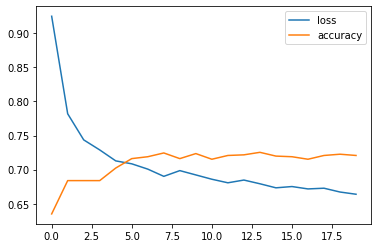

In [39]:
losses.plot()

## Modeled without: max_features=max_len

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect=TfidfVectorizer()
X_train_tfidf=tfidf_vect.fit_transform(X_train).toarray()
X_test_tfidf=tfidf_vect.transform(X_test).toarray()
X_train_tfidf=pd.DataFrame(X_train_tfidf)
X_test_tfidf=pd.DataFrame(X_test_tfidf)

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

In [42]:
model_2=Sequential()
model_2.add(Dense(activation='relu',units=64))
model_2.add(Dropout(0.2))
model_2.add(Dense(activation='relu',units=32))
model_2.add(Dense(activation='softmax',units=3))
model_2.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [43]:
history_2=model_2.fit(x=X_train_tfidf,y=y_train,epochs=20)

Epoch 1/20
34/34 [==============================] - 0s 4ms/step - loss: 0.9161 - accuracy: 0.6802
Epoch 2/20
34/34 [==============================] - 0s 4ms/step - loss: 0.6824 - accuracy: 0.6848
Epoch 3/20
34/34 [==============================] - 0s 4ms/step - loss: 0.5565 - accuracy: 0.7512
Epoch 4/20
34/34 [==============================] - 0s 4ms/step - loss: 0.4372 - accuracy: 0.8212
Epoch 5/20
34/34 [==============================] - 0s 4ms/step - loss: 0.3300 - accuracy: 0.8885
Epoch 6/20
34/34 [==============================] - 0s 4ms/step - loss: 0.2509 - accuracy: 0.9097
Epoch 7/20
34/34 [==============================] - 0s 4ms/step - loss: 0.1970 - accuracy: 0.9189
Epoch 8/20
34/34 [==============================] - 0s 4ms/step - loss: 0.1498 - accuracy: 0.9410
Epoch 9/20
34/34 [==============================] - 0s 4ms/step - loss: 0.1201 - accuracy: 0.9558
Epoch 10/20
34/34 [==============================] - 0s 4ms/step - loss: 0.0902 - accuracy: 0.9724
Epoch 11/20
34/34 [

In [44]:
y_predictions=(model_2.predict(X_test_tfidf) > 0.5).astype("int32")

In [45]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print(classification_report(y_test,y_predictions))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90       182
           1       0.82      0.69      0.75        78
           2       0.86      0.50      0.63        12

   micro avg       0.86      0.85      0.85       272
   macro avg       0.85      0.71      0.76       272
weighted avg       0.85      0.85      0.85       272
 samples avg       0.85      0.85      0.85       272



In [46]:
print(accuracy_score(y_test,y_predictions))

0.8492647058823529


In [47]:
confusion_matrix(y_test.argmax(axis=1),y_predictions.argmax(axis=1))

array([[172,  10,   0],
       [ 23,  54,   1],
       [  4,   2,   6]], dtype=int64)

<AxesSubplot:>

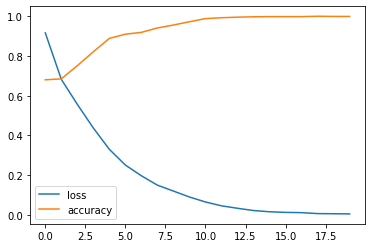

In [48]:
losses=pd.DataFrame(history_2.history)
losses.plot()